In [ ]:
# !unzip text_data.zip

In [ ]:
from my_dataset import MyDataset
from load_data import *
from preprocess import *
# from run_torch_model import *
from run_torch_model_CUDA import *
from text_model import *

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from collections import Counter
import numpy as np
from sklearn.metrics import classification_report
import time
import csv
import os

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
print('Using device: ', device)

Using device:  cuda


In [ ]:
# Checking the type of GPU
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla T4, 418.67, 15079 MiB


In [ ]:
folder = 'text_data'

# AGN Data
agn_sub_folder = 'agn_small'
agn_path = os.path.join(folder, agn_sub_folder)

# DBPedia Data
dbpedia_sub_folder = 'dbpedia_small'
dbpedia_path = os.path.join(folder, dbpedia_sub_folder)

# Loading both datasets
train_agn, dev_agn, test_agn = load_data(agn_path)
train_dbpedia, dev_dbpedia, test_dbpedia = load_data(dbpedia_path)

In [ ]:
train_agn[0]['text']

"Fannie Mae Discloses Document Request The mortgage giant said today that prosecutors had asked the company to preserve documents as part of an investigation into Fannie Mae's accounting practices."

In [ ]:
print("AGN DATA")
print("TRAINING ", len(train_agn))
print("DEV ", len(dev_agn))
print("TEST ", len(test_agn))
print("DBPEDIA DATA")
print("TRAINING ", len(train_dbpedia))
print("DEV ", len(dev_dbpedia))
print("TEST ", len(test_dbpedia))

AGN DATA
TRAINING  5000
DEV  5000
TEST  5000
DBPEDIA DATA
TRAINING  5000
DEV  10000
TEST  10000


In [ ]:
train_texts_agn = [x['text'] for x in train_agn]
train_labels_agn = [x['label'] for x in train_agn]
dev_texts_agn = [x['text'] for x in dev_agn]
dev_labels_agn = [x['label'] for x in dev_agn]
test_texts_agn = [x['text'] for x in test_agn]
test_labels_agn = [x['label'] for x in test_agn]

In [ ]:
np.unique(train_labels_agn)

array([0, 1, 2, 3])

In [ ]:
train_texts_dbpedia = [x['text'] for x in train_dbpedia]
train_labels_dbpedia = [x['label'] for x in train_dbpedia]
dev_texts_dbpedia = [x['text'] for x in dev_dbpedia]
dev_labels_dbpedia = [x['label'] for x in dev_dbpedia]
test_texts_dbpedia = [x['text'] for x in test_dbpedia]
test_labels_dbpedia = [x['label'] for x in test_dbpedia]

In [ ]:
np.unique(train_labels_dbpedia)

array(['1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7',
       '8', '9'], dtype='<U2')

In [ ]:
def _non_rare_vocabulary(texts, min_freq=20): # <------------ IMPORTANT PARAMETER

    counter = Counter(texts[0])

    for text in texts[1:]:
        counter += Counter(text)

    print("Size of vocabulary BEFORE removing rare tokens: ", len(counter))

    sorted_items = sorted(counter.items(), key = lambda x: x[1])

    index = 0

    for sorted_item in sorted_items:
        
        if sorted_item[1] >= min_freq:
            break
            
        index+=1
        
    print("Size of vocabulary AFTER  removing rare tokens: ", len(sorted_items[index:]))
        
    return [x[0] for x in sorted_items[index:]]


def _bag_of_words(texts, vocabulary):

    bow = np.zeros((len(texts), len(vocabulary)))
    
    for ii in range(len(texts)):
        
        for word in texts[ii]:
            
            if word in vocabulary:
                
                bow[ii, vocabulary.index(word)] += 1
                
    return bow


def _term_document_frequency(term, texts):

    counter = 0
    
    for text in texts:
        if term in text:
            counter += 1
            
    if counter == 0:
      print("TERM WITH 0 doc_freq ", term)

    return counter


def _idf(texts, vocabulary):
    
    doc_freq = np.zeros((len(vocabulary),))
    N = len(texts)
                        
    for ii in range(len(vocabulary)):
        doc_freq[ii] = np.log(N / _term_document_frequency(vocabulary[ii], texts))
        
    return doc_freq


def _tf_idf( texts, vocabulary):
    
    # Instantiate results
    tfidf = np.zeros((len(texts), len(vocabulary)))
    
    # One-off calculation of Inverse Document Frequency
    doc_freq = _idf(texts, vocabulary)
    
    for ii in range(len(texts)):
        # Find Term Frequency for each word in a text
        for word in texts[ii]:
            
            if word in vocabulary:
                
                tfidf[ii, vocabulary.index(word)] += 1
        
        # Multiply the Term Frequency by Inverse Document Frequency
        tfidf[ii, ] *= tfidf[ii, ] * doc_freq
                
    return tfidf



# TRAINING

In [ ]:
texts = train_texts_agn
labels = train_labels_agn
val_texts = dev_texts_agn
val_labels = dev_labels_agn
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
preprocessed_texts = preprocess_texts(texts)
print("FINISHED PREPROCESSING")
vocabulary = _non_rare_vocabulary(preprocessed_texts
                                  , min_freq = 10)
print("DEFINED VOCABULARY")

FINISHED PREPROCESSING
Size of vocabulary BEFORE removing rare tokens:  17186
Size of vocabulary AFTER  removing rare tokens:  2594
DEFINED VOCABULARY


In [ ]:
# TRAINING DATA

# BAG OF WORDS
# features = _bag_of_words(preprocessed_texts, vocabulary)

# TFIDF
features = _tf_idf(preprocessed_texts, vocabulary)

print("FEATURES.shape ", features.shape)

FEATURES.shape  (5000, 2594)


In [ ]:
'kuznetsova' in vocabulary

True

In [ ]:
# VALIDATION DATA
preprocessed_val_texts = preprocess_texts(val_texts)

# val_features = _bag_of_words(preprocessed_val_texts, vocabulary)

val_features = _tf_idf(preprocessed_val_texts, vocabulary)

print("VAL_FEATURES.shape ", val_features.shape)

TERM WITH 0 doc_freq  kuznetsova


ZeroDivisionError: ignored

In [ ]:
# TRAINING
train_dataset = MyDataset(features, labels)
val_dataset = MyDataset(val_features, val_labels)

model = Text_Classifier(input_size = len(vocabulary)
                        , output_size = len(np.unique(labels)))

trained_model, loss, accuracy = run_model(model
                                          , running_mode='train'
                                          , train_set = train_dataset
                                          , valid_set = val_dataset
                                          , batch_size = 10
                                          , stop_thr=1e-4
                                          , learning_rate = 1e-4 * 10
                                          , n_epochs = 100
                                          , shuffle = True
                                          , device=device)

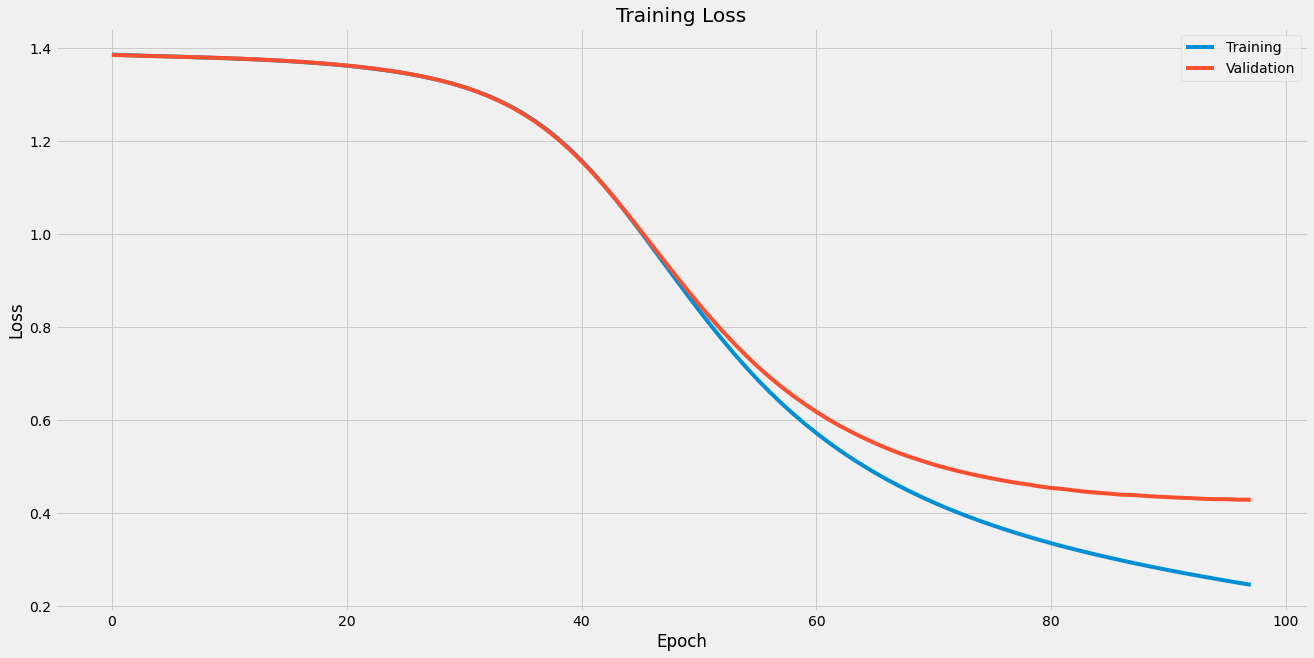

In [ ]:
plt.figure(figsize=(20,10))
n_epochs = 98
plt.plot(range(n_epochs), loss['train'], label='Training')
plt.plot(range(n_epochs), loss['valid'], label='Validation')

plt.title('Training Loss')
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend()

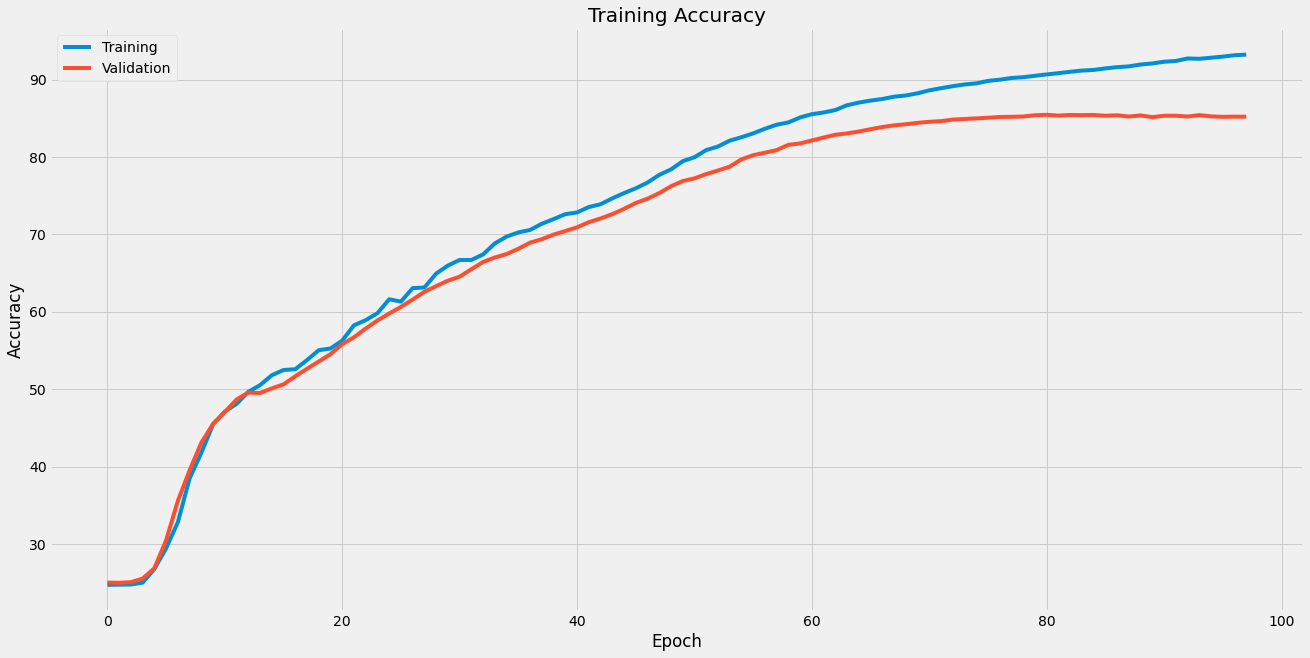

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(range(n_epochs), accuracy['train'], label='Training')
plt.plot(range(n_epochs), accuracy['valid'], label='Validation')

plt.title('Training Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend()

# TESTING

In [ ]:
test_texts = test_texts_agn
test_labels = test_labels_agn

In [ ]:
preprocessed_test_texts = preprocess_texts(test_texts)

test_features = _bag_of_words  (preprocessed_test_texts, vocabulary)

test_dataset = MyDataset(test_features, test_labels) # dummy labels

test_dataloader = torch.utils.data.DataLoader(test_dataset
                                                , batch_size=len(test_features) # Will just 1 batch work?
                                                , shuffle=False
                                                , num_workers=2) 

with torch.no_grad():

    for batch, labels in test_dataloader:

        batch, labels = batch.to(device), labels.to(device)

        output = trained_model(batch.float())

        predicted = torch.max(output.data, 1)[1]

In [ ]:
print(classification_report(test_labels,predicted.cpu()))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1250
           1       0.91      0.94      0.92      1250
           2       0.81      0.80      0.80      1250
           3       0.82      0.80      0.81      1250

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



In [ ]:
test_loss, test_accuracy = run_model(model
                                      , running_mode='test'
                                      , test_set = test_dataset
                                      , batch_size = len(test_features)
                                      , shuffle = True)

In [ ]:
test_loss

0.4524252414703369

In [ ]:
test_accuracy

84.88

# <<<<<<<<<< TRAINING WITH GLOVE >>>>>>>>>>>>

In [ ]:
# !unzip text_data.zip

In [ ]:
from my_dataset import MyDataset
from load_data import *
from preprocess import *
# from run_torch_model import *
from run_torch_model_CUDA import *
from text_model import *

import gensim.downloader
import gensim

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from collections import Counter
import numpy as np
from sklearn.metrics import classification_report
import time
import csv
import os

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
print('Using device: ', device)

Using device:  cuda


In [ ]:
nltk.download('stopwords')
print("DONE WITH STOPWORDS DOWNLOAD")
# glove = gensim.downloader.load('glove-wiki-gigaword-50')
glove = gensim.downloader.load('glove-wiki-gigaword-300')
print("DONE WITH GLOVE DOWNLOAD")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
DONE WITH STOPWORDS DOWNLOAD
[============================================------] 88.7% 333.5/376.1MB downloaded
DONE WITH GLOVE DOWNLOAD


In [ ]:
folder = 'text_data'

# AGN Data
agn_sub_folder = 'agn_small'
agn_path = os.path.join(folder, agn_sub_folder)

# DBPedia Data
dbpedia_sub_folder = 'dbpedia_small'
dbpedia_path = os.path.join(folder, dbpedia_sub_folder)

# Loading both datasets
train_agn, dev_agn, test_agn = load_data(agn_path)
train_dbpedia, dev_dbpedia, test_dbpedia = load_data(dbpedia_path)

# Texts & Labels - AGN
train_texts_agn = [x['text'] for x in train_agn]
train_labels_agn = [x['label'] for x in train_agn]
dev_texts_agn = [x['text'] for x in dev_agn]
dev_labels_agn = [x['label'] for x in dev_agn]
test_texts_agn = [x['text'] for x in test_agn]
test_labels_agn = [x['label'] for x in test_agn]

# Texts & Labels - DBPedia
train_texts_dbpedia = [x['text'] for x in train_dbpedia]
train_labels_dbpedia = [x['label'] for x in train_dbpedia]
dev_texts_dbpedia = [x['text'] for x in dev_dbpedia]
dev_labels_dbpedia = [x['label'] for x in dev_dbpedia]
test_texts_dbpedia = [x['text'] for x in test_dbpedia]
test_labels_dbpedia = [x['label'] for x in test_dbpedia]

In [ ]:
train_texts_dbpedia[0]

' Coleophora acutipennella is a moth of the Coleophoridae family. It is found in North America including California.'

In [ ]:
def docs_to_vecs(texts):

    doc_vecs = []
    
    for text in texts:

        lst_vec = []
    
        for word in text:
            try:
                lst_vec.append(glove.get_vector(word))
            except:
                pass # Ignore word if it's not in vocabulary of glove_50
    
        vec = np.array(lst_vec)
        np_vec = np.concatenate((np.min(vec, axis=0), np.max(vec, axis=0), np.mean(vec, axis=0)))

        doc_vecs.append(np_vec)
    
    return np.array(doc_vecs)

## Working with AGN data

In [ ]:
preprocessed_train_texts = preprocess_texts(train_texts_agn)
print("PREPROCESSED TRAIN TEXTS: ", len(preprocessed_train_texts))
preprocessed_dev_texts = preprocess_texts(dev_texts_agn)
print("PREPROCESSED DEV TEXTS: ", len(preprocessed_dev_texts))
preprocessed_test_texts = preprocess_texts(test_texts_agn)
print("PREPROCESSED TEST TEXTS: ", len(preprocessed_test_texts))

PREPROCESSED TRAIN TEXTS:  5000
PREPROCESSED DEV TEXTS:  5000
PREPROCESSED TEST TEXTS:  5000


In [ ]:
train_features = docs_to_vecs(preprocessed_train_texts)
print("TRAIN FEATURES SHAPE ", train_features.shape)
dev_features = docs_to_vecs(preprocessed_dev_texts)
print("DEV FEATURES SHAPE ", dev_features.shape)
test_features = docs_to_vecs(preprocessed_test_texts)
print("TEST FEATURES SHAPE ", test_features.shape)

TRAIN FEATURES SHAPE  (5000, 900)
DEV FEATURES SHAPE  (5000, 900)
TEST FEATURES SHAPE  (5000, 900)


In [ ]:
train_dataset = MyDataset(train_features, train_labels_agn)
dev_dataset = MyDataset(dev_features, dev_labels_agn)
test_dataset = MyDataset(test_features, test_labels_agn)

In [ ]:
model = Text_Classifier(input_size = train_features.shape[1]
                        , output_size = len(np.unique(train_labels_agn)))

trained_model, loss, accuracy = run_model(model
                                          , running_mode='train'
                                          , train_set = train_dataset
                                          , valid_set = dev_dataset
                                          , batch_size = 1
                                          , stop_thr=1e-4
                                          , learning_rate = 1e-4 * 5
                                          , n_epochs = 150
                                          , shuffle = True
                                          , device=device)

STARTING EPOCH #0
STARTING EPOCH #1
STARTING EPOCH #2
STARTING EPOCH #3
STARTING EPOCH #4
STARTING EPOCH #5
STARTING EPOCH #6
STARTING EPOCH #7
STARTING EPOCH #8
STARTING EPOCH #9
REACHED STOP CONDITION
OLD_VALID_LOSS  0.36964614606411195
NEW_VALID_LOSS  0.3853264065092197


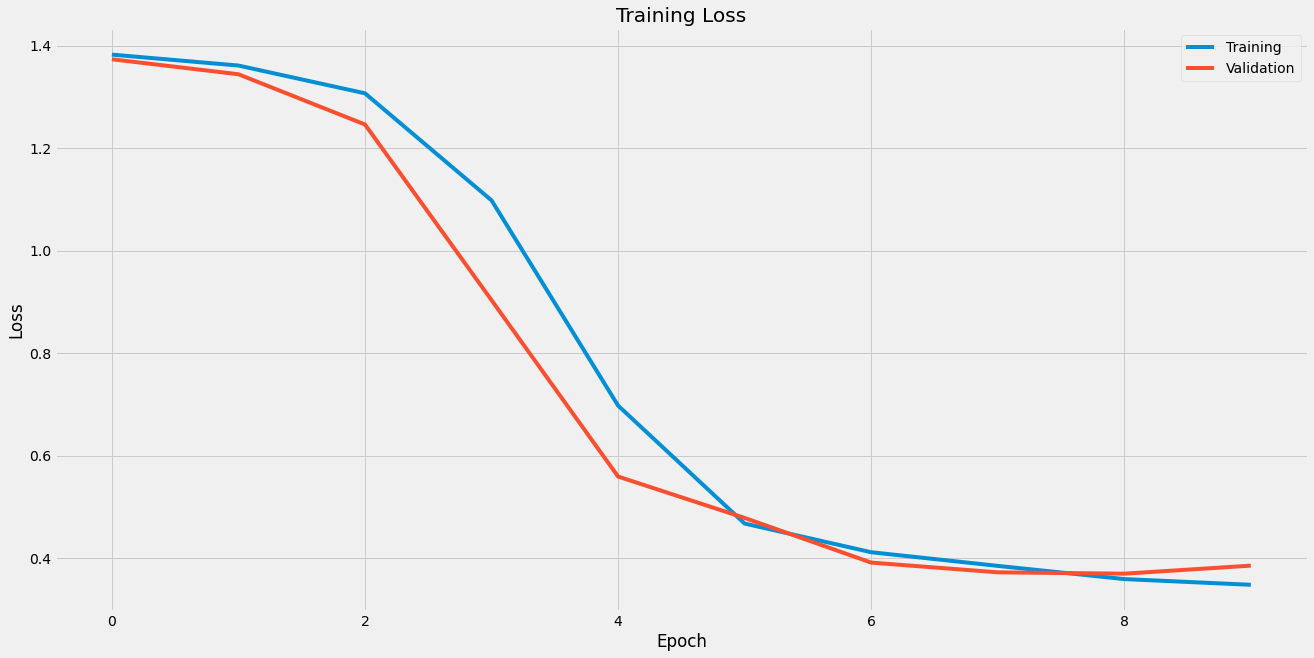

In [ ]:
plt.figure(figsize=(20,10))
n_epochs = 10
plt.plot(range(n_epochs), loss['train'], label='Training')
plt.plot(range(n_epochs), loss['valid'], label='Validation')

plt.title('Training Loss')
plt.ylabel("Loss")
plt.xlabel('Epoch')
plt.legend()

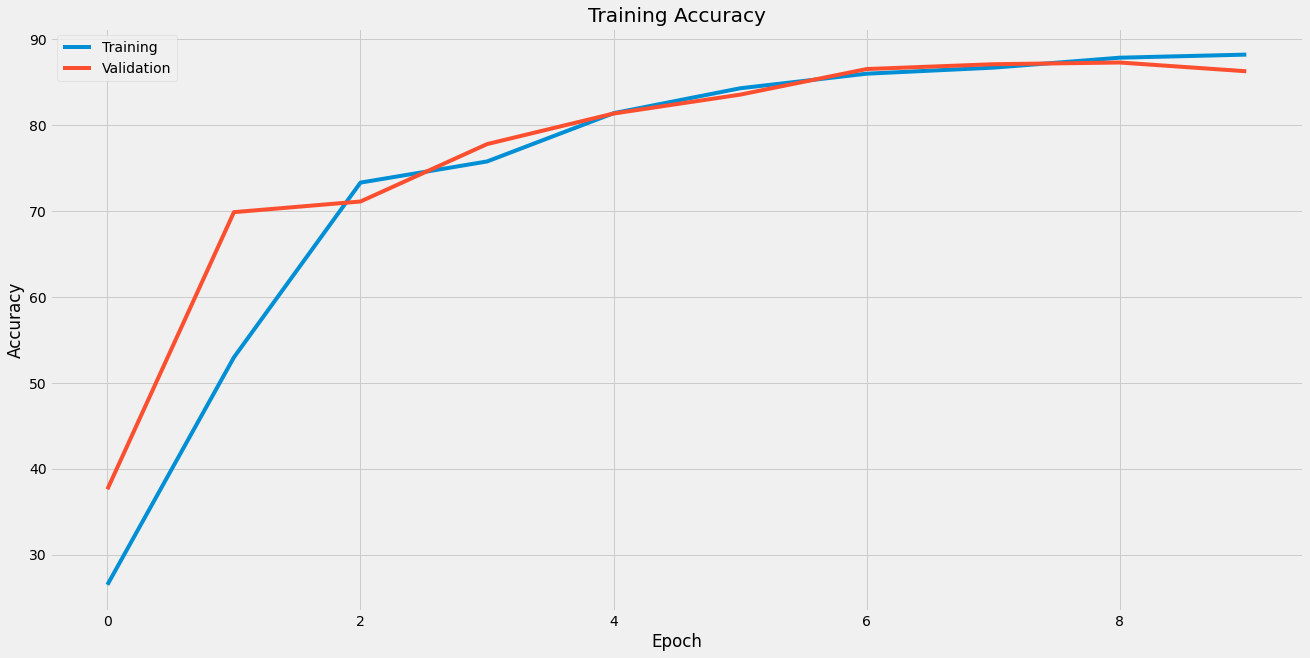

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(range(n_epochs), accuracy['train'], label='Training')
plt.plot(range(n_epochs), accuracy['valid'], label='Validation')

plt.title('Training Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.legend()

## TESTING

In [ ]:
test_loss, test_accuracy = run_model(model
                                      , running_mode='test'
                                      , test_set = test_dataset
                                      , batch_size = len(test_features)
                                      , shuffle = True)

print("TEST LOSS ", test_loss)
print("TEST ACCURACY ", test_accuracy)

TEST LOSS  0.39780834317207336
TEST ACCURACY  85.66


In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset
                                                , batch_size=len(test_dataset) # Will just 1 batch work?
                                                , shuffle=False
                                                , num_workers=2) 

with torch.no_grad():

    for batch, labels in test_dataloader:

        batch, labels = batch.to(device), labels.to(device)

        output = trained_model(batch.float())

        predicted = torch.max(output.data, 1)[1]

print(classification_report(test_labels_agn, predicted.cpu()))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1250
           1       0.95      0.95      0.95      1250
           2       0.72      0.92      0.81      1250
           3       0.90      0.70      0.79      1250

    accuracy                           0.86      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.87      0.86      0.86      5000



## Working with DBPedia

In [ ]:
preprocessed_train_texts_dbpedia = preprocess_texts(train_texts_dbpedia)
print("PREPROCESSED TRAIN TEXTS: ", len(preprocessed_train_texts_dbpedia))
preprocessed_dev_texts_dbpedia = preprocess_texts(dev_texts_dbpedia)
print("PREPROCESSED DEV TEXTS: ", len(preprocessed_dev_texts_dbpedia))
preprocessed_test_texts_dbpedia = preprocess_texts(test_texts_dbpedia)
print("PREPROCESSED TEST TEXTS: ", len(preprocessed_test_texts_dbpedia))

PREPROCESSED TRAIN TEXTS:  5000
PREPROCESSED DEV TEXTS:  10000
PREPROCESSED TEST TEXTS:  10000


In [ ]:
train_texts_dbpedia[779]

' The Ss.'

In [ ]:
def docs_to_vecs_dbpedia(texts):
 

In [ ]:
train_features_dbpedia = docs_to_vecs_dbpedia(preprocessed_train_texts_dbpedia)
print("TRAIN FEATURES SHAPE ", train_features_dbpedia.shape)
dev_features_dbpedia = docs_to_vecs_dbpedia(preprocessed_dev_texts_dbpedia)
print("DEV FEATURES SHAPE ", dev_features_dbpedia.shape)
test_features_dbpedia = docs_to_vecs_dbpedia(preprocessed_test_texts_dbpedia)
print("TEST FEATURES SHAPE ", test_features_dbpedia.shape)

TRAIN FEATURES SHAPE  (5000, 900)
DEV FEATURES SHAPE  (10000, 900)
TEST FEATURES SHAPE  (10000, 900)


In [ ]:
train_dataset_dbpedia = MyDataset(torch.Tensor(train_features_dbpedia), train_labels_dbpedia)
dev_dataset_dbpedia = MyDataset(torch.Tensor(dev_features_dbpedia), dev_labels_dbpedia)
test_dataset_dbpedia = MyDataset(torch.Tensor(test_features_dbpedia), test_labels_dbpedia)

In [ ]:
train_dataloader_dbpedia = torch.utils.data.DataLoader(train_dataset_dbpedia
                                                        , batch_size=10
                                                        , shuffle=False # I think for the test dataset I don't need shuffle=True
                                                        , num_workers=2) 

In [ ]:
for batch, labels in train_dataloader_dbpedia:
    print(batch.shape)
    break

torch.Size([10, 900])


## TRAINING

In [ ]:
model = Text_Classifier(input_size = train_features_dbpedia.shape[1]
                        , output_size = len(np.unique(train_labels_dbpedia)))

trained_model, loss, accuracy = run_model(model
                                          , running_mode='train'
                                          , train_set = train_dataset_dbpedia
                                          , valid_set = dev_dataset_dbpedia
                                          , batch_size = 1
                                          , stop_thr=1e-4
                                          , learning_rate = 1e-4 * 5
                                          , n_epochs = 150
                                          , shuffle = True
                                          , device=device)

STARTING EPOCH #0


AttributeError: ignored